<a href="https://colab.research.google.com/github/sanjay235/Sketch2Image-translation/blob/master/Sketch2Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyunpack

  Created wheel for pyunpack: filename=pyunpack-0.1.2-cp36-none-any.whl size=5162 sha256=759715d8e9e762173e94d36a143ac72d11d4d97078f12b8467ca3dc3eb6acdd4
  Stored in directory: /root/.cache/pip/wheels/af/44/08/60613970881e542c0baad1f2dea5ed8e6716bc573f49197b7e
Successfully built pyunpack


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.activations import tanh, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import tensorflow as tf

import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
from google.colab import files
from datetime import datetime
from pyunpack import Archive
from IPython import display
from PIL import Image
import numpy as np
import imageio
import random
import glob
import math

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .23

rand_seed = random.randint(0, 2 ** 31 - 1)

tf.set_random_seed(rand_seed)
np.random.seed(rand_seed)
random.seed(rand_seed)

In [0]:
Archive('drive/My Drive/Sketch2Image/AnimeData.zip').extractall('.')

(512, 512)


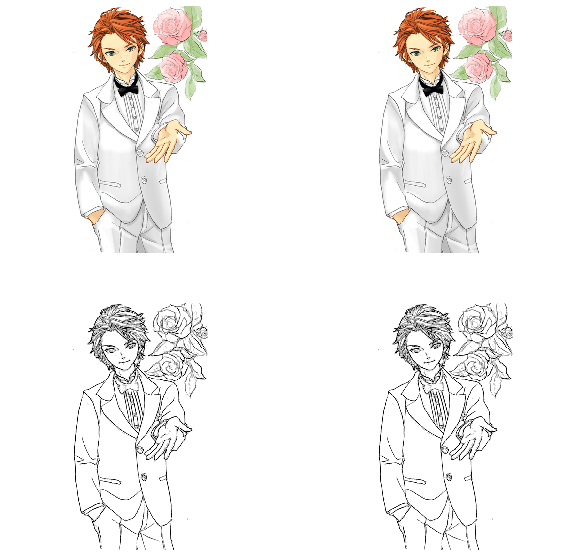

In [0]:
img = Image.open('Images/235.png').convert('RGB')
img2 = Image.open('Sketches/235.png').convert('RGB')

print(img.size)

f,a = plt.subplots(2, 2, figsize=(10,10))
a = a.flatten()

for ax, i in zip(a, [img, img.resize((512, 512), Image.LANCZOS), img2, img2.resize((512, 512), Image.LANCZOS)]):
  ax.imshow(i)
  ax.axis('off')

plt.subplots_adjust(wspace=.2, hspace=.2)
plt.show()

## Generator:

In [0]:
def convBlock(inp, n_filters, filter_size=4, stride=2, dropout=False, activation=True, BN=True, padding='same'):

  y = Conv2D(n_filters, filter_size, stride, padding, kernel_initializer=tf.keras.initializers.truncated_normal(stddev=.02))(inp)

  if BN:
    y = BatchNormalization()(y)

  if activation:
    y = LeakyReLU(.2)(y)

  print(y.shape)
  return y

def convTransBlock(inp, n_filters, filter_size=4, stride=2, convOut=None, dropout=False, activation=True, BN=True, padding='same'):

  y = Conv2DTranspose(n_filters, filter_size, stride, padding,\
                      kernel_initializer=tf.keras.initializers.truncated_normal(stddev=.02))(concatenate([inp, convOut]) if convOut is not None else inp)

  if BN:
    y = BatchNormalization()(y)

  if dropout:
    y = Dropout(rate=dropout)(y)
  
  if activation:
    y = LeakyReLU(.2)(y)

  print(y.shape)
  return y

In [0]:
def generator(drop_rate, inp_shape=(512, 512, 3)):
  n_filters = 16
  
  inp = Input(inp_shape)

  print('Encoder:')
  conv1 = convBlock(inp, n_filters, BN=False) # 256x256
  conv2 = convBlock(conv1, n_filters*2,)      # 128x128
  conv3 = convBlock(conv2, n_filters*4,)      # 64x64
  conv4 = convBlock(conv3, n_filters*8,)      # 32x32
  conv5 = convBlock(conv4, n_filters*8,)      # 16x16
  conv6 = convBlock(conv5, n_filters*8,)      # 8x8
  conv7 = convBlock(conv6, n_filters*8,)      # 4x4
  conv8 = convBlock(conv7, n_filters*8,)      # 2x2x512

  print('Decoder:')
  deconv1 = convTransBlock(conv8, n_filters*8)                                     # 4x4
  deconv2 = convTransBlock(deconv1, n_filters*8, convOut=conv7, dropout=drop_rate) # 8x8
  deconv3 = convTransBlock(deconv2, n_filters*8, convOut=conv6, dropout=drop_rate) # 16x16
  deconv4 = convTransBlock(deconv3, n_filters*8, convOut=conv5, dropout=drop_rate) # 32x32
  deconv5 = convTransBlock(deconv4, n_filters*4, convOut=conv4)                    # 64x64
  deconv6 = convTransBlock(deconv5, n_filters*2, convOut=conv3)                    # 128x128
  deconv7 = convTransBlock(deconv6, n_filters, convOut=conv2)                      # 256x256
  deconv8 = convTransBlock(deconv7, 3, convOut=conv1, activation=False, BN=False)  # 512x512

  outp = tanh(deconv8)

  model = Model(inputs=inp, outputs=outp)

  return model

In [0]:
# m = generator()

## Discriminator:

In [0]:
def discriminator(inp_shape=(512, 512, 3), target_shape=(512, 512, 3)):
  n_filters = 16
  
  inp1 = Input(inp_shape) # sketch input
  inp2 = Input(target_shape) # colored input

  inp = concatenate([inp1, inp2]) # 512x512x6

  conv1 = convBlock(inp, n_filters, BN=False) # 256x256x64
  conv2 = convBlock(conv1, n_filters*2) # 128x128x128
  conv3 = convBlock(conv2, n_filters*4) # 64x64x256
  conv4 = convBlock(conv3, n_filters*8) # 32x32x512
  conv5 = convBlock(conv4, n_filters*8, filter_size=2, stride=1, padding='valid') # 31x31x512
  conv6 = convBlock(conv5, n_filters=1, filter_size=2, stride=1, activation=False, BN=False, padding='valid') # 30x30x1

  sigmoid_outp = sigmoid(conv6)
  
  outp = GlobalAveragePooling2D()(sigmoid_outp)

  model = Model(inputs=[inp1, inp2], outputs=outp)

  opt = Adam(lr=.0002, beta_1=.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  
  return model

In [0]:
# m = discriminator()

## Losses:

In [8]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
553467904/553467096 [==============================] - 12s 0us/step


In [0]:
# https://stackoverflow.com/a/45963039/9079093

def featureLevel_loss(y, g, vggnet1, vggnet2):

  def finalFLoss(y_true, y_pred):
    # https://stackoverflow.com/a/56707761/9079093
    # y_loss = vggnet1.predict(y)
    # g_loss = vggnet2.predict(g)
    return K.mean(K.sqrt( K.sum(K.square( y - g )) ) )
  
  return finalFLoss

def totalVariation_loss(g):

  def finalTVLoss(y_true, y_pred):
    return K.mean(K.abs( K.sqrt( K.sum(K.square(g[:, 1:, :, :] - g[:, :-1, :, :])) + K.sum(K.square(g[:, :, 1:, :] - g[:, :, :-1, :])) ) ))
  
  return finalTVLoss

def pixelLevel_loss(y, g):
  
  def finalPLoss(y_true, y_pred):
    return K.mean(K.abs( y - g ))
  
  return finalPLoss


def binaryCrossEntropy(from_logits=False):
  
  def finalBCELoss(y_true, y_pred):
    return  K.mean(K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
  
  return finalBCELoss

In [0]:
K.resize_images(Input((512,512,3)), 224, 224, 'channels_last')

In [0]:
tf.image.resize(Input((512,512,3)), (224, 224), tf.image.ResizeMethod.NEAREST_NEIGHBOR)

## GAN:

In [0]:
vgg_net1 = Model(inputs=vgg.input, outputs=ReLU()(vgg.get_layer('block2_conv2').output))
vgg_net2 = Model(inputs=vgg.input, outputs=ReLU()(vgg.get_layer('block2_conv2').output))

def define_gan(g_model, d_model, vgg_net1, vgg_net2, inp_shape=(512, 512, 3)):
  
  d_model.trainable = False

  # ======= Generator ======= #
  sketch_inp = Input(inp_shape)
  gen_color_output = g_model([sketch_inp])
	
	# ======= Discriminator ======= #
  disc_outputs = d_model([sketch_inp, gen_color_output])
  
  color_inp = Input(inp_shape)
	
  # =================== PixelLevel Loss =================== #
  pixelLevelLoss = pixelLevel_loss(color_inp, gen_color_output)
  
  # =================== TotalVariation Loss =================== #
  totalVariationLoss = totalVariation_loss(gen_color_output)

  # =================== FeatureLevel Loss =================== # 
  # Output dimensions must be positive keras backend resize_images : https://stackoverflow.com/a/57218765/9079093
  
  # K.resize_images(color_inp, .4375, .4375, 'channels_last', 'bilinear')
  net1_outp = vgg_net1([tf.image.resize(color_inp, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  
  # K.resize_images(gen_color_output, .4375, .4375, 'channels_last', 'bilinear') 
  net2_outp = vgg_net2([tf.image.resize(gen_color_output, (224, 224), tf.image.ResizeMethod.BILINEAR)])

  featureLevelLoss = featureLevel_loss(net1_outp,\
                                       net2_outp,\
                                       vgg_net1, vgg_net2)
  
  # =================== CrossEntropy Loss =================== #
  crossEntropyLoss = binaryCrossEntropy()
  
  # =================== Final Model =================== #
  model = Model(inputs=[sketch_inp, color_inp], outputs=disc_outputs)
  
  opt = Adam(lr=.0002, beta_1=.5)
	
  # Single output multiple loss functions in keras : https://stackoverflow.com/a/51705573/9079093
  model.compile(loss=lambda y_true, y_pred : tf.keras.losses.binary_crossentropy(y_true, y_pred) + \
                                             100*pixelLevelLoss(y_true, y_pred) + \
                                             .0001*totalVariationLoss(y_true, y_pred) + \
                                             .001*featureLevelLoss(y_true, y_pred),\
                optimizer=opt)
	
  return model

## Build and compile models:

In [27]:
g_model = generator(drop_rate=.5)

d_model = discriminator()

gan = define_gan(g_model, d_model, vgg_net1, vgg_net2)
gan.summary()

Encoder:
(?, 256, 256, 16)
(?, 128, 128, 32)
(?, 64, 64, 64)
(?, 32, 32, 128)
(?, 16, 16, 128)
(?, 8, 8, 128)
(?, 4, 4, 128)
(?, 2, 2, 128)
Decoder:
(?, 4, 4, 128)
(?, 8, 8, 128)
(?, 16, 16, 128)
(?, 32, 32, 128)
(?, 64, 64, 64)
(?, 128, 128, 32)
(?, 256, 256, 16)
(?, 512, 512, 3)
(?, 256, 256, 16)
(?, 128, 128, 32)
(?, 64, 64, 64)
(?, 32, 32, 128)
(?, 31, 31, 128)
(?, 30, 30, 1)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 512, 512, 3)  3408803     input_5[0][0]                    
__________________________________________________________________________________________________
input_

## Utils:

In [0]:
!rm ./Sketch2Image/*

In [0]:
!mkdir ./Sketch2Image/

In [0]:
def save_plot(examples, epoch, n=3):
  n = int(math.sqrt(n))
  plt.figure(figsize=(6, 6))
  examples = (examples + 1) / 2.0
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i])
  filename = './Sketch2Image/generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.show()

def summarize_performance(epoch, g_model, d_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, n_samples=9):
	
	X_real_sketches, X_real_images, y_real = generate_real_samples(sketch_paths, image_paths, n_samples)
	
	_, acc_real = d_model.evaluate([X_real_sketches, X_real_images], y_real, verbose=0)
	
	x_fake_sketches, x_fake_images, y_fake = generate_fake_samples(g_model, sketch_paths, image_paths, latent_dim, n_samples, seed_skets=seed_skets, seed_imgs=seed_imgs)
	
	_, acc_fake = d_model.evaluate([x_fake_sketches, x_fake_images], y_fake, verbose=0)
	
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	
	save_plot(x_fake_images, epoch, n_samples)

	# filename = 'generator_model_%03d.h5' % (epoch+1)
	# g_model.save(filename)

def generate_real_samples(sketch_paths, image_paths, n_samples, offset=None):
  ix = np.random.randint(0, TOTAL_IMAGES, n_samples)
  X_sketches = []
  X_images = []
  
  for sket, img in zip(sketch_paths[ix], image_paths[ix]):
    X_sketches.append(np.array(Image.open(sket).convert('RGB')))
    X_images.append(np.array(Image.open(img).convert('RGB')))
  
  X_sketches = (np.array(X_sketches, dtype='float32')-127.5)/127.5
  X_images = (np.array(X_images, dtype='float32')-127.5)/127.5
  y = np.ones((n_samples, 1))
	
  return X_sketches, X_images, y

def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(g_model, sketch_paths, image_paths, latent_dim, n_samples, seed_skets=None, seed_imgs=None):
	# x_input = generate_latent_points(latent_dim, n_samples)
	# X = g_model.predict(seed if seed is not None else x_input)
	
  X_sketches = []
  X_images = []

  if seed_skets is not None:
    
    X_images = g_model.predict(seed_skets)
    y = np.zeros((n_samples, 1))

    return seed_skets, X_images, y

  elif g_model is not None:

    ix = np.random.randint(0, TOTAL_IMAGES, n_samples)
    
    for sket in sketch_paths[ix]:
      X_sketches.append(np.array(Image.open(sket).convert('RGB')))
    
    X_sketches = (np.array(X_sketches, dtype='float32')-127.5)/127.5
    X_images = g_model.predict(X_sketches)
    y = np.zeros((n_samples, 1))
    
    return X_sketches, X_images, y
  
  else:
    ix = np.random.randint(0, TOTAL_IMAGES, n_samples)
    
    for sket, img in zip(sketch_paths[ix], image_paths[ix]):
      X_sketches.append(np.array(Image.open(sket).convert('RGB')))
      X_images.append(np.array(Image.open(img).convert('RGB')))
    
    X_sketches = (np.array(X_sketches, dtype='float32')-127.5)/127.5
    X_images = (np.array(X_images, dtype='float32')-127.5)/127.5
    y = np.zeros((n_samples, 1))

    return X_sketches, X_images, y

## Training Util:

In [0]:
def train(g_model, d_model, gan_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, n_epochs=100, n_batch=128, init_epoch=0):
  bat_per_epo = int(TOTAL_IMAGES / n_batch)
  half_batch = int(n_batch / 2)
  
  for i in range(init_epoch, n_epochs):
    start = datetime.now()
    for j in range(bat_per_epo):
      # ======================== Train discrimintor on real images ========================= #
      if not j%2:
        X_real_skets, X_real_imgs, y_real = generate_real_samples(sketch_paths, image_paths, half_batch)
        
        d_loss1, _ = d_model.train_on_batch([X_real_skets, X_real_imgs], y_real * .9)
      # ======================== Train discrimintor on real images ========================= #

      if not j%3:
      # ======================== Train discrimintor on fake images ========================= #
        X_fake_skets, X_fake_imgs, y_fake = generate_fake_samples(g_model, sketch_paths, image_paths, latent_dim, half_batch)

        d_loss2, _ = d_model.train_on_batch([X_fake_skets, X_fake_imgs], y_fake)
      # ======================== Train discrimintor on fake images ========================= #
      
      
      # ======================== Train generator on latent points ========================= #
      X_gan_skets, X_gan_imgs, _ = generate_fake_samples(None, sketch_paths, image_paths, latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      
      g_loss = gan_model.train_on_batch([X_gan_skets, X_gan_imgs], y_gan)
      # ======================== Train generator on latent points ========================= #
      
      if not j%10:
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

    display.clear_output(True)
    print('Time for epoch {} : {}'.format(i+1,datetime.now()-start))
    print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    summarize_performance(i, g_model, d_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, seed_skets.shape[0])
  
  display.clear_output(True)      
  print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  summarize_performance(i, g_model, d_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, seed_skets.shape[0])

## Train:

In [0]:
img_paths = glob.glob('Images/*.png')
sketch_paths = glob.glob('Sketches/*.png')

global TOTAL_IMAGES
TOTAL_IMAGES = len(sketch_paths)

img_paths.sort()
sketch_paths.sort()

img_paths = np.array(img_paths)
sketch_paths = np.array(sketch_paths)

>30, 222/222, d1=0.394, d2=0.012 g=45.911
>Accuracy real: 0%, fake: 100%


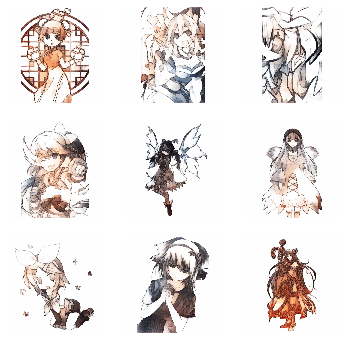

In [31]:
# ================ Seed sketches for checking progress after every epoch ================ # 
seed_skets = []
seed_imgs = []
idxs = np.random.randint(0, TOTAL_IMAGES, 9)

for sket, img in zip(sketch_paths[idxs], img_paths[idxs]):
    seed_skets.append(np.array(Image.open(sket).convert('RGB')))
    seed_imgs.append(np.array(Image.open(img).convert('RGB')))
  
seed_skets = (np.array(seed_skets, dtype='float32')-127.5)/127.5
seed_imgs = (np.array(seed_imgs, dtype='float32')-127.5)/127.5
# ================ Seed sketches for checking progress after every epoch ================ #


# ======================================= Start training ======================================= #
train(g_model, d_model, gan, sketch_paths, img_paths, 100, seed_skets, seed_imgs, 30, n_batch=64, init_epoch=2)
# ======================================= Start training ======================================= #

In [0]:
save_model(g_model, 'generator_epoch_30.h5')

>38, 222/222, d1=0.326, d2=0.025 g=49.998
>Accuracy real: 0%, fake: 100%


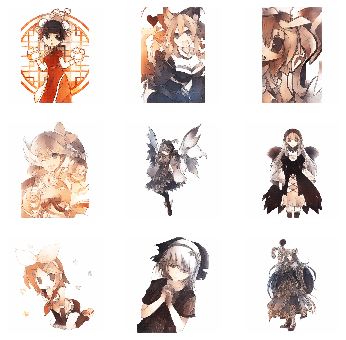

In [35]:
train(g_model, d_model, gan, sketch_paths, img_paths, 100, seed_skets, seed_imgs, 38, n_batch=64, init_epoch=31)

In [0]:
save_model(g_model, 'generator_epoch_38.h5')

## Output of train data sketches :

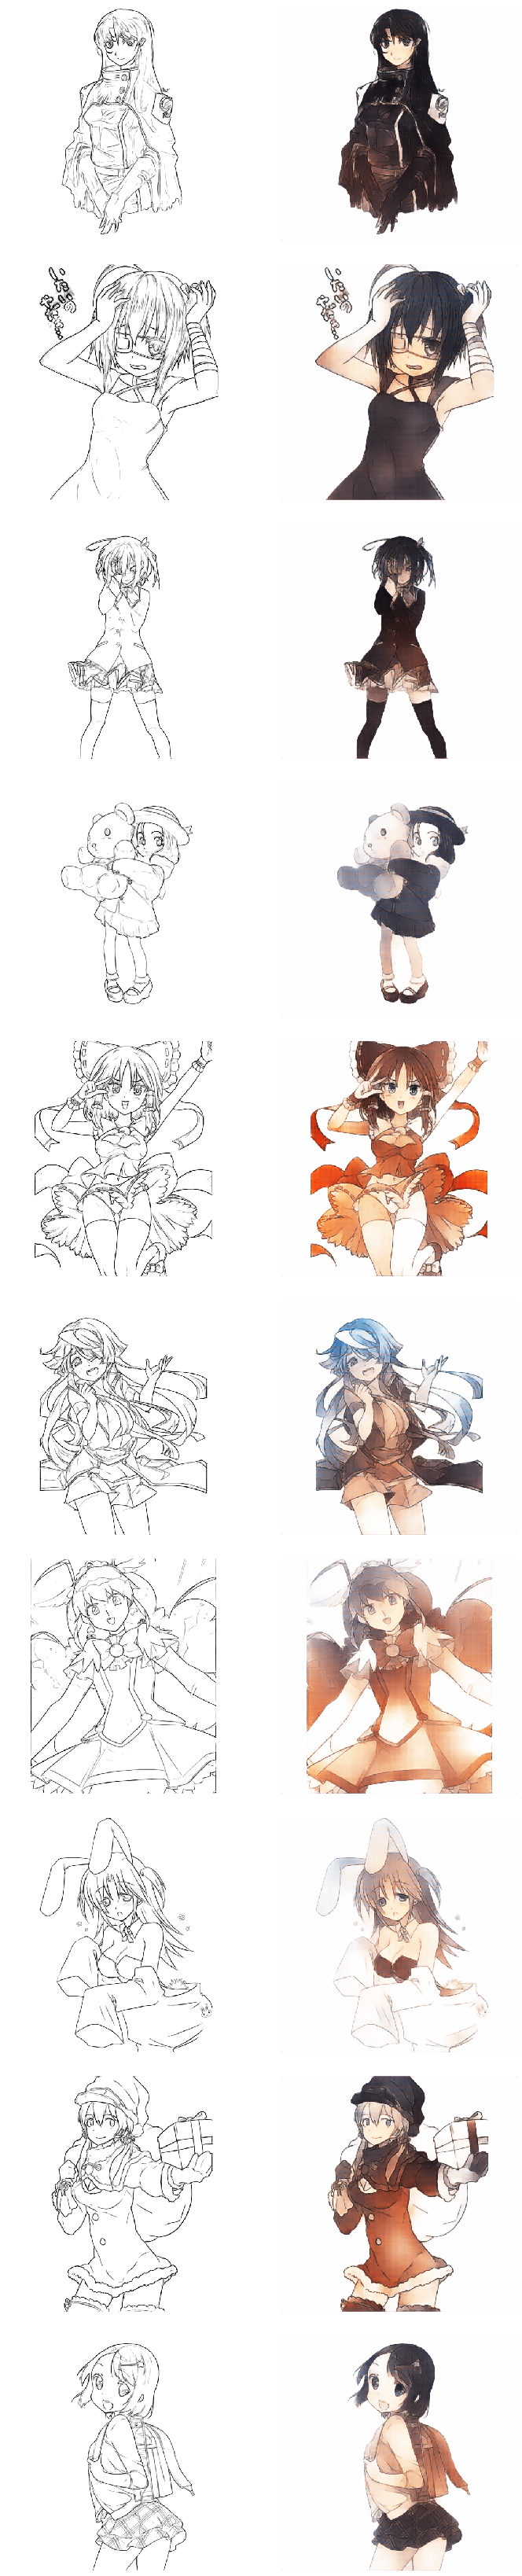

In [49]:
k = 10

temp_skets = []
temp_imgs = []
idx=np.random.randint(0, TOTAL_IMAGES, k)

for sket, img in zip(sketch_paths[idx], img_paths[idx]):
    temp_skets.append(np.array(Image.open(sket).convert('RGB')))
    temp_imgs.append(np.array(Image.open(img).convert('RGB')))

temp_skets = np.array(temp_skets, dtype='float32')/127.5 - 1

pred = g_model.predict(temp_skets)
pred = (pred+1)/2.0
temp_skets = (temp_skets+1)/2.0

f, a = plt.subplots(k, 2, figsize=(12,60))
a = a.flatten()

idx = 0
for sket, pic in zip(temp_skets, pred):
  a[idx].imshow(sket)
  a[idx+1].imshow(pic)
  a[idx].axis('off')
  a[idx+1].axis('off')
  idx += 2

plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('Sketch2Image/generated_plot_e*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**5.23)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [0]:
files.download(anim_file)

In [0]:
def saveModels(gan, generator, discriminator):
    discriminator.trainable = False
    save_model(gan, 'gan.h5')
    discriminator.trainable = True
    save_model(generator, 'generator.h5')
    save_model(discriminator, 'discriminator.h5')


def loadModels():
    discriminator = load_model('discriminator.h5')
    generator = load_model('generator.h5')
    gan = load_model('gan.h5')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

saveModels(gan, g_model, d_model)

In [0]:
from google.colab import files

files.download('generator.h5')
files.download('gan.h5')
files.download('discriminator.h5')

## Output of test data sketches :

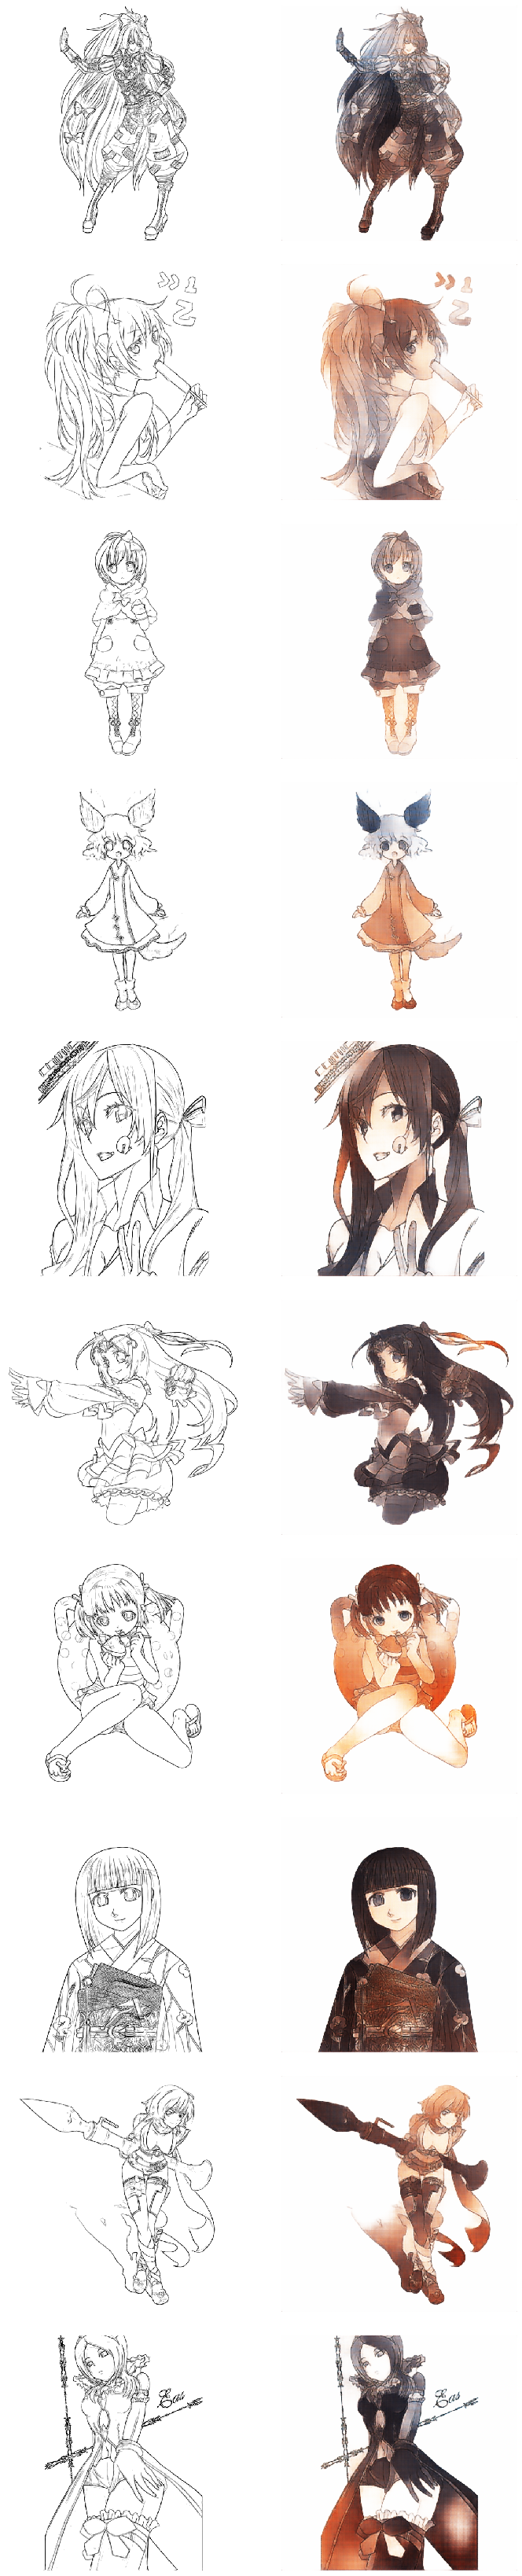

In [52]:
temp_skets = []

for sket in glob.glob('*.png')[5:15]:
    temp_skets.append(np.array(Image.open(sket).convert('RGB')))

temp_skets = np.array(temp_skets, dtype='float32')/127.5 - 1

pred = g_model.predict(temp_skets)
pred = (pred+1)/2.0
temp_skets = (temp_skets+1)/2.0

f, a = plt.subplots(temp_skets.shape[0], 2, figsize=(12, 60))
a = a.flatten()

idx = 0
for sket, pic in zip(temp_skets, pred):
  a[idx].imshow(sket)
  a[idx+1].imshow(pic)
  a[idx].axis('off')
  a[idx+1].axis('off')
  idx += 2

plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

## Referencs:

[1] https://arxiv.org/abs/1705.01908

[2] https://machinelearningmastery.com

[3] https://github.com/soumith/ganhacks

[4] Dataset : https://www.kaggle.com/ktaebum/anime-sketch-colorization-pair